In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [138]:
import time

import cv2
import numpy as np

from lib.tsdf_fusion import fusion

from tqdm import tqdm

import os, os.path as osp
from pathlib import Path

import matplotlib.pyplot as plt

In [139]:
DATA_DIR = Path('/mnt/data/scannet/scans/')

In [186]:
scan_id = 'scene0001_00'
scan_dir = DATA_DIR / scan_id
pose_dir = scan_dir / 'pose'
depth_dir = scan_dir / 'depth'
color_dir = scan_dir / 'color'

intrinsic_dir = scan_dir / 'intrinsic'
intrinsic_path = intrinsic_dir / 'intrinsic_color.txt'
intrinsic_mat = np.genfromtxt(intrinsic_path, delimiter=' ')[:3, :3]

/mnt/data/scannet/scans/scene0001_00/depth/0.png
0 4627 (480, 640)


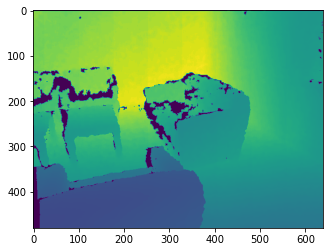

In [188]:
# read a depth image and display it
fpath = depth_dir / '0.png'
print(fpath)
img = cv2.imread(str(fpath), -1)
print(img.min(), img.max(), img.shape)
plt.imshow(img)

## Get volume vounds

In [196]:
vol_bnds = np.zeros((3,2))

for depth_name in tqdm(os.listdir(depth_dir)):
    # index of the file - needed when frames are skipped
    ndx = Path(depth_name).stem
    pose = np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' ')
#     pose = np.linalg.inv(np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' '))
    
    depth = cv2.imread(str(depth_dir / depth_name), -1).astype(float)
    # convert mm to m
    depth /= 1000.0
    
    view_frust_pts = fusion.get_view_frustum(depth, intrinsic_mat, pose)
    # todo: why does this return nan values?
    if not np.isnan(view_frust_pts).any():
        vol_bnds[:,0] = np.minimum(vol_bnds[:,0], np.amin(view_frust_pts, axis=1))
        vol_bnds[:,1] = np.maximum(vol_bnds[:,1], np.amax(view_frust_pts, axis=1))

100%|██████████| 1544/1544 [00:05<00:00, 291.92it/s]


In [197]:
vol_bnds

array([[-1.00597741, 11.51918074],
       [-1.34446344, 12.39730994],
       [-1.91009034,  3.72304051]])

## Create voxel grid

In [199]:
tsdf_vol = fusion.TSDFVolume(vol_bnds, voxel_size=0.04)

t0_elapse = time.time()

for depth_name in tqdm(os.listdir(depth_dir)):
    ndx = Path(depth_name).stem
    pose = np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' ')
    
    color = cv2.imread(str(color_dir / f'{ndx}.jpg'), cv2.IMREAD_COLOR)
    depth = cv2.imread(str(depth_dir / depth_name), -1).astype(float)
                       
    # convert mm to m
    depth /= 1000.0
    
    tsdf_vol.integrate(color, depth, intrinsic_mat, pose, obs_weight=1.)
    
fps = len(os.listdir(depth_dir)) / (time.time() - t0_elapse)
print("Average FPS: {:.2f}".format(fps))

Voxel volume size: 314 x 344 x 142 - # points: 15,338,272


100%|██████████| 1544/1544 [16:47<00:00,  1.53it/s]

Average FPS: 1.53


In [200]:
tsdf, color_float = tsdf_vol.get_volume()
print('tsdf', tsdf.min(), tsdf.max(), tsdf.shape)
print('color_float', color_float.min(), color_float.max(), color_float.shape)

rgb = float_color_to_int(color_float)
print(rgb.min(), rgb.max(), rgb.shape)

tsdf -0.99999845 1.0 (314, 344, 142)
color_float 0.0 16777215.0 (314, 344, 142)
0 255 (314, 344, 142, 3)


In [128]:
def float_color_to_int(arr):
    '''
    arr: float32 containing color
        = R, G, B 8 bits each
    '''
    const = 256 * 256
    # rightmost value
    b = np.floor(arr / const)
    # middle value
    g = np.floor((arr - b * const)/256)
    # leftmost value
    r = arr - (b * const) - (g * 256)
    
    rgb = np.floor(np.stack((r, g, b), axis=-1)).astype(np.uint8)
    
    return rgb 


## save mesh

In [201]:
verts, faces, norms, colors = tsdf_vol.get_mesh()
fusion.meshwrite(scan_dir / f'{scan_id}_voxelized.ply', verts, faces, norms, colors)

In [202]:
point_cloud = tsdf_vol.get_point_cloud()
fusion.pcwrite(scan_dir / f'{scan_id}_pc.ply', point_cloud)